Initial approach will be to observe what happens when document retrieval is done separately on train and dev datasets. 
---

In [1]:
%%time

# Importing necessary libraries

import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud, ImageColorGenerator

CPU times: user 747 ms, sys: 166 ms, total: 914 ms
Wall time: 904 ms


In [2]:
%%time


'''
Reading from input file and doing json normalizing upon the train data to achieve the required 
dataframe format
'''
def convert_from_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers']):
    file = json.loads(open(file_path).read())
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file, record_path[:-2])
    index = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = index
    data = m[['id', 'question', 'context', 'answers']].set_index('id').reset_index()
    data['context_id'] = data['context'].factorize()[0]
    return data
    

train_file_path = '/content/train-v1.1.json'
train_data = convert_from_json_to_dataframe(train_file_path)
train_data

CPU times: user 3.95 s, sys: 121 ms, total: 4.07 s
Wall time: 4.1 s


,id,question,context,answers,context_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.","[{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}]",0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.","[{'answer_start': 188, 'text': 'a copper statue of Christ'}]",0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame is beside to which structure?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.","[{'answer_start': 279, 'text': 'the Main Building'}]",0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.","[{'answer_start': 381, 'text': 'a Marian place of prayer and reflection'}]",0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre Dame?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, Franc

In [3]:
%%time

# Exploring the train dataset a bit more!

print ('Number of unique contexts in the train dataset :', len(train_data['context_id'].unique()))

Number of unique contexts in the train dataset : 18891
CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 3.89 ms


In [4]:
%%time

# Getting unique documents from the train dataset

train_unique_documents = train_data[['context', 'context_id']].drop_duplicates().reset_index(drop=True)
train_unique_documents

CPU times: user 124 ms, sys: 1 ms, total: 125 ms
Wall time: 125 ms


,context,context_id
0,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",0
1,"As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some students believed that The Observer began to show a conservative bias, a liberal newspaper, Common Sense was published. Likewise, in 2003, when other students believed that the paper showed a liberal bias, the conservative paper Irish Rover went into production. Neither paper is published as often as The Observer; however, all three are distributed to all students. Finally, in Spring 2008 an undergraduate journal for political science research, Beyond Politics, made its debut.",1
2,"The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.",2
3,"The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study – aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering – with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.",3
4,"All of Notre Dame's undergraduate students are a part of one of the five undergraduate colleges at the school or are in the First Year of Studies program. The First Year of Studies program was established in 1962 to guide incoming freshmen in their first year at the school before they have declared a major. Each student is given an academic advisor from the program who helps them to choose classes that give them exp

In [5]:
%%time

'''
Brief overview of the algorithm to be followed :- 
(1) Creation of the document vectorizer. 
(2) Use of the above document vectorizer to encode the documents and the questions into vectors. 
(3) Search for a question comparing with the document vectors. 
(4) Return the 'k' most similar document vectors to a question vector.

For vectorization, TF-IDF can be used.
Wikipedia says this about TF-IDF -> It is a numerical statistic that is intended to reflect how important 
a word is to a document in a collection or corpus and is often used as a weighting factor in searches of 
information retrieval, text mining, and user modeling.  
'''

# Defining the TF-IDF vectorizer and the number of documents to retrieve 
retriever_configs = {'n_neighbors' : 3, 'metric' : 'cosine'}
tfidf_configs = {'lowercase' : True, 'analyzer' : 'word', 'stop_words' : 'english', 'binary' : True, 
                 'max_features' : 50_000}

# Fixing the pipeline
embedding = TfidfVectorizer(**tfidf_configs)
retriever = NearestNeighbors(**retriever_configs)

# Training the model to retrieve the document id 'context_id'
X_train = embedding.fit_transform(train_unique_documents['context'])
retriever.fit(X_train, train_unique_documents['context_id'])

CPU times: user 2.39 s, sys: 22.6 ms, total: 2.41 s
Wall time: 2.76 s


NearestNeighbors(metric='cosine', n_neighbors=3)

In [6]:
%%time


# Vectorizing a sample question
def transform_text(vectorizer, text):
    print ('Text :', text)
    vector = vectorizer.transform([text])
    vector = vectorizer.inverse_transform(vector)
    print ('Vector :', vector)
    

question = 'What are the tourist hostspots in Spain?'
transform_text(embedding, question)

Text : What are the tourist hostspots in Spain?
Vector : [array(['tourist', 'spain'], dtype='<U27')]
CPU times: user 39.7 ms, sys: 899 µs, total: 40.6 ms
Wall time: 45.8 ms


In [7]:
%%time

# Retrieving the most similar document to the above question and vectorizing the retrieved document

X_question = embedding.transform([question])
context_id = retriever.kneighbors(X_question, return_distance=False)[0][0]
selected_document = train_unique_documents.iloc[context_id]['context']

transform_text(embedding, selected_document)

Text : Galicia was late to catch the tourism boom that has swept Spain in recent decades, but the coastal regions (especially the Rías Baixas and Santiago de Compostela) are now significant tourist destinations and are especially popular with visitors from other regions in Spain, where the majority of tourists come from. In 2007, 5.7 million tourists visited Galicia, an 8% growth over the previous year, and part of a continual pattern of growth in this sector. 85% of tourists who visit Galicia visit Santiago de Compostela. Tourism constitutes 12% of Galician GDP and employs about 12% of the regional workforce.
Vector : [array(['year', 'workforce', 'visitors', 'visited', 'visit', 'tourists',
       'tourist', 'tourism', 'swept', 'spain', 'significant', 'sector',
       'santiago', 'rías', 'regions', 'regional', 'recent', 'previous',
       'popular', 'pattern', 'million', 'majority', 'late', 'growth',
       'gdp', 'galician', 'galicia', 'especially', 'employs',
       'destinations', '

In [8]:
%%time

# Predicting the top 3 documents for each question

X_train = embedding.transform(train_data['question'])
y_test = train_data['context_id']
y_pred = retriever.kneighbors(X_train, return_distance=False)

print (y_pred)

[[    0  3694 10613]
 [    7  1469     2]
 [   38  1469     0]
 ...
 [18890 18886 18836]
 [18890 18870 18841]
 [18857 18890     2]]
CPU times: user 26.8 s, sys: 7.72 s, total: 34.6 s
Wall time: 41.4 s


In [9]:
%%time

# Testing the model upon the training set
def compute_accuracy(y_test, y_pred):
    num_correct, num_total = 0, len(y_test)
    for i in range(num_total):
        y_pred_list = y_pred[i]
        if y_test[i] in y_pred_list:
            num_correct += 1
    return num_correct / num_total


acc = compute_accuracy(y_test, y_pred)
print('Accuracy:', f'{acc:.4f}')

Accuracy: 0.7182
CPU times: user 670 ms, sys: 1.44 ms, total: 672 ms
Wall time: 671 ms


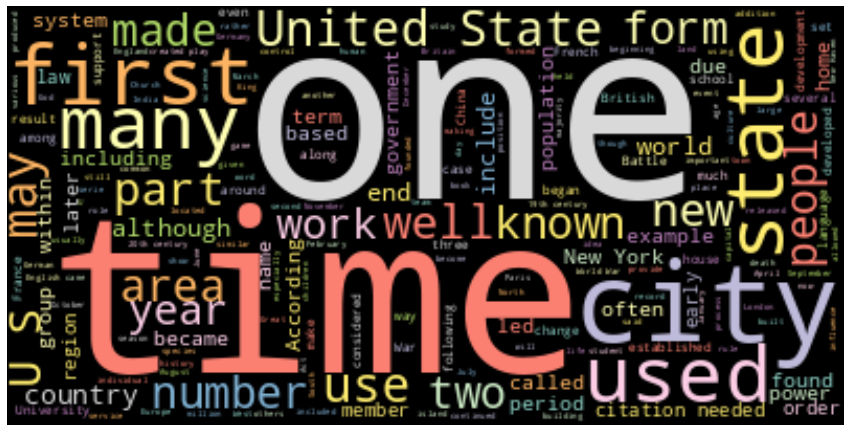

<Figure size 720x432 with 0 Axes>

CPU times: user 24.9 s, sys: 1.17 s, total: 26 s
Wall time: 26.1 s


In [10]:
%%time

# Generating word cloud for the train dataset

def generate_wordcloud(data):
    data_context = data[['id', 'context']]
    text = ' '.join(str(word) for word in data_context.context)
    wordcloud = WordCloud(max_words=200, colormap='Set3', background_color="black").generate(text)
    plt.figure(figsize=(10,6))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='Bilinear')
    plt.axis("off")
    plt.figure(1,figsize=(12, 12))
    plt.show()


generate_wordcloud(train_data)

Now, we dive into the dev dataset...
---

In [11]:
%%time

# Loading the validation data

dev_file_path = '/content/dev-v1.1.json'
dev_data = convert_from_json_to_dataframe(dev_file_path)
print (dev_data.shape)
dev_data

(10570, 5)
CPU times: user 719 ms, sys: 4.28 ms, total: 723 ms
Wall time: 757 ms


,id,question,context,answers,context_id
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bowl 50?,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.","[{'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}]",0
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bowl 50?,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.","[{'answer_start': 249, 'text': 'Carolina Panthers'}, {'answer_start': 249, 'text': 'Carolina Panthers'}, {'answer_start': 249, 'text': 'Carolina Panthers'}]",0
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.","[{'answer_start': 403, 'text': 'Santa Clara, California'}, {'answer_start': 355, 'text': 'Levi's Stadium'}, {'answer_start': 355, 'text': 'Levi's Stadium in the San Francisco Bay Area at Santa Clara, California.'}]",0
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.","[{'answer_start

In [12]:
%%time

# Exploring the dev dataset a bit more!

print ('Number of unique contexts :', len(dev_data['context_id'].unique()))

Number of unique contexts : 2067
CPU times: user 1.38 ms, sys: 59 µs, total: 1.44 ms
Wall time: 1.44 ms


In [13]:
%%time

# Getting unique documents from the dev dataset

dev_unique_documents = dev_data[['context', 'context_id']].drop_duplicates().reset_index(drop=True)
dev_unique_documents

CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 22.1 ms


,context,context_id
0,"Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the ""golden anniversary"" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as ""Super Bowl L""), so that the logo could prominently feature the Arabic numerals 50.",0
1,"The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated the Arizona Cardinals 49–15 in the NFC Championship Game and advanced to their second Super Bowl appearance since the franchise was founded in 1995. The Broncos finished the regular season with a 12–4 record, and denied the New England Patriots a chance to defend their title from Super Bowl XLIX by defeating them 20–18 in the AFC Championship Game. They joined the Patriots, Dallas Cowboys, and Pittsburgh Steelers as one of four teams that have made eight appearances in the Super Bowl.",1
2,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",2
3,"CBS broadcast Super Bowl 50 in the U.S., and charged an average of $5 million for a 30-second commercial during the game. The Super Bowl 50 halftime show was headlined by the British rock group Coldplay with special guest performers Beyoncé and Bruno Mars, who headlined the Super Bowl XLVII and Super Bowl XLVIII halftime shows, respectively. It was the third-most watched U.S. broadcast ever.",3
4,"In early 2012, NFL Commissioner Roger Goodell stated that the league planned to make the 50th Super Bowl ""spectacular"" and that it would be ""an important game for us as a league"".",4
...,...,...
2062,"where is the mass of the object, is the velocity of the object and is the distance to the center of the circular path and is the unit vector pointing in the radial direction outwards from the center. This means that the unbalanced centripetal force felt by any object is always directed toward the center of the curving path. Such forces act perpendicular to the velocity vector associated with the motion of an object, and therefore do not change the speed of the object (magnitude of the velocity), but only the direction of the velocity vector. The unbalanced force that accelerates an object can be resolved into a component that is perpendicular to the path, and one that is tangential to the path. This yields both the tangential force, which accelerates the object by either slowing it down or speeding it up, and the radial (centripetal) force, which changes its direction.",2062
2063,"A conservative force that acts on a closed system has an associated mechanical work that allows energy to convert only between kinetic or potential forms. This means that for a closed system, the net mechanical energy is conserved whenever a conservative force acts on the system. The force, therefore, is related directly to the difference in potential energy between two different locations in space, and can be considered to be an artifact of the potential field in the same way that the direction and amount of a flow of water can be considered to be an artifact of the contour map of the elevation of an area.",2063
2064,"For certain physical scenarios, it is impossible to model forces a

In [14]:
%%time

# Training the dev model to retrieve the document id 'context_id'
X_dev = embedding.fit_transform(dev_unique_documents['context'])
retriever.fit(X_dev, dev_unique_documents['context_id'])

CPU times: user 229 ms, sys: 791 µs, total: 229 ms
Wall time: 230 ms


NearestNeighbors(metric='cosine', n_neighbors=3)

In [15]:
%%time

# Visualizing how a sample question is transformed into a vector by the above defined model

question = 'What are some of the tourist hotspots in Spain?'
transform_text(embedding, question)

Text : What are some of the tourist hotspots in Spain?
Vector : [array(['tourist', 'spain'], dtype='<U23')]
CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 18 ms


In [16]:
%%time

# Retrieving the most similar document to the above question and vectorizing the retrieved document

X_question = embedding.transform([question])
context_id = retriever.kneighbors(X_question, return_distance=False)[0][0]
selected_document = dev_unique_documents.iloc[context_id]['context']

transform_text(embedding, selected_document)

Text : Southern California is divided culturally, politically, and economically into distinctive regions, each containing its own culture and atmosphere, anchored usually by a city with both national and sometimes global recognition, which are often the hub of economic activity for its respective region and being home to many tourist destinations. Each region is further divided into many culturally distinct areas but as a whole combine to create the southern California atmosphere.
Vector : [array(['usually', 'tourist', 'southern', 'respective', 'regions',
       'region', 'recognition', 'politically', 'national', 'hub', 'home',
       'global', 'economically', 'economic', 'divided', 'distinctive',
       'distinct', 'destinations', 'culture', 'culturally', 'create',
       'containing', 'combine', 'city', 'california', 'atmosphere',
       'areas', 'anchored', 'activity'], dtype='<U23')]
CPU times: user 19.1 ms, sys: 0 ns, total: 19.1 ms
Wall time: 21.3 ms


In [17]:
%%time

# Predicting the top 3 documents for each question from the dev data

X_dev = embedding.transform(dev_data['question'])
y_test = dev_data['context_id']
y_pred = retriever.kneighbors(X_dev, return_distance=False)

print (y_pred)

[[   4    0    1]
 [   4    0   17]
 [  35   30    3]
 ...
 [2066 2062 1607]
 [2066 1960 1912]
 [ 225 2031  279]]
CPU times: user 439 ms, sys: 78.7 ms, total: 518 ms
Wall time: 521 ms


In [18]:
%%time

# Testing the model upon the dev set

acc = compute_accuracy(y_test, y_pred)
print('Accuracy:', f'{acc:.4f}')

Accuracy: 0.8488
CPU times: user 88.8 ms, sys: 171 µs, total: 89 ms
Wall time: 89.7 ms


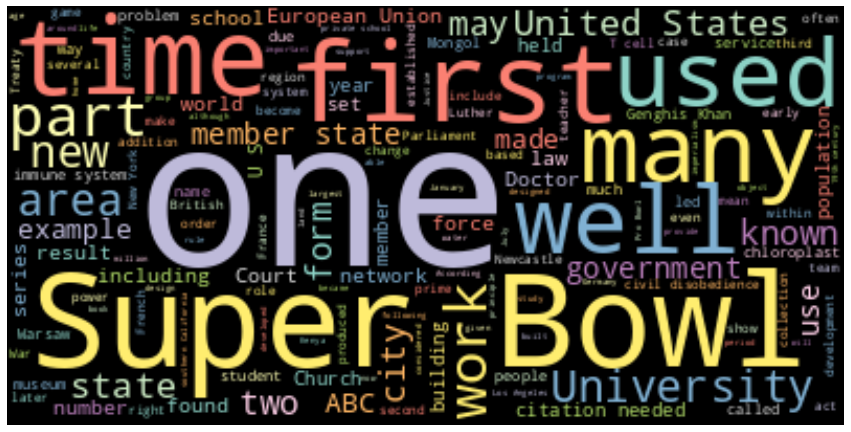

<Figure size 720x432 with 0 Axes>

CPU times: user 3.34 s, sys: 153 ms, total: 3.49 s
Wall time: 3.4 s


In [19]:
%%time

# Generating wordcloud for the dev dataset
generate_wordcloud(dev_data)

Now, we club together both the train and the dev datasets together and compute the accuracy of the above defined model.
---

In [20]:
%%time

# Before clubbing, a bit of pre-processing on the context_id values of the dev dataset

dev_data['context_id'] = dev_data['context_id'] + len(train_data['context_id'].unique())

CPU times: user 1.81 ms, sys: 0 ns, total: 1.81 ms
Wall time: 1.95 ms


In [21]:
%%time

# Concatenating the train and dev datasets and exploring the whole data a bit more!

complete_data = pd.concat([train_data, dev_data], ignore_index=True)
print ('Number of unique contexts :', len(complete_data['context_id'].unique()))

Number of unique contexts : 20958
CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 12.2 ms


In [22]:
%%time

# Getting unique documents from the complete dataset

complete_unique_documents = complete_data[['context', 'context_id']].drop_duplicates().reset_index(drop=True)
complete_unique_documents

CPU times: user 131 ms, sys: 534 µs, total: 132 ms
Wall time: 144 ms


,context,context_id
0,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.",0
1,"As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some students believed that The Observer began to show a conservative bias, a liberal newspaper, Common Sense was published. Likewise, in 2003, when other students believed that the paper showed a liberal bias, the conservative paper Irish Rover went into production. Neither paper is published as often as The Observer; however, all three are distributed to all students. Finally, in Spring 2008 an undergraduate journal for political science research, Beyond Politics, made its debut.",1
2,"The university is the major seat of the Congregation of Holy Cross (albeit not its official headquarters, which are in Rome). Its main seminary, Moreau Seminary, is located on the campus across St. Joseph lake from the Main Building. Old College, the oldest building on campus and located near the shore of St. Mary lake, houses undergraduate seminarians. Retired priests and brothers reside in Fatima House (a former retreat center), Holy Cross House, as well as Columba Hall near the Grotto. The university through the Moreau Seminary has ties to theologian Frederick Buechner. While not Catholic, Buechner has praised writers from Notre Dame and Moreau Seminary created a Buechner Prize for Preaching.",2
3,"The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study – aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering – with eight B.S. degrees offered. Additionally, the college offers five-year dual degree programs with the Colleges of Arts and Letters and of Business awarding additional B.A. and Master of Business Administration (MBA) degrees, respectively.",3
4,"All of Notre Dame's undergraduate students are a part of one of the five undergraduate colleges at the school or are in the First Year of Studies program. The First Year of Studies program was established in 1962 to guide incoming freshmen in their first year at the school before they have declared a major. Each student is given an academic advisor from the program who helps them to choose classes that give them exp

In [23]:
%%time

# Training the dev model to retrieve the document id 'context_id'
X_complete = embedding.fit_transform(complete_unique_documents['context'])
retriever.fit(X_complete, complete_unique_documents['context_id'])

CPU times: user 1.93 s, sys: 6.24 ms, total: 1.94 s
Wall time: 1.94 s


NearestNeighbors(metric='cosine', n_neighbors=3)

In [24]:
%%time

# Vectorizing a sample question

question = 'What are the tourist hotspots in Spain?'
transform_text(embedding, question)

Text : What are the tourist hotspots in Spain?
Vector : [array(['tourist', 'spain', 'hotspots'], dtype='<U27')]
CPU times: user 30.5 ms, sys: 0 ns, total: 30.5 ms
Wall time: 33.3 ms


In [25]:
%%time

# Retrieving the most similar document to the above question and vectorizing the retrieved document

X_question = embedding.transform([question])
context_id = retriever.kneighbors(X_question, return_distance=False)[0][0]
selected_document = complete_unique_documents.iloc[context_id]['context']

transform_text(embedding, selected_document)

Text : Tourist hotspots in Portugal are Lisbon, Algarve, Madeira, Porto and the city of Coimbra, also, between 4-5 million religious pilgrims visit Fátima each year, where apparitions of the Blessed Virgin Mary to three shepherd children reportedly took place in 1917. The Sanctuary of Fátima is one of the largest Roman Catholic shrines in the world. The Portuguese government continues to promote and develop new tourist destinations, such as the Douro Valley, the island of Porto Santo, and Alentejo. Lisbon is the 16th European city which attracts the most tourists (with seven million tourists occupying the city's hotels in 2006, a number that grew 11.8% compared to previous year). Lisbon in recent years surpassed the Algarve as the leading tourist region in Portugal. Porto and Northern Portugal, especially the urban areas north of Douro River valley, was the tourist destination which grew most (11.9%) in 2006, surpassing Madeira (in 2010), as the third most visited destination.[citation

In [26]:
%%time

# Predicting the top 3 documents for each question from the dev data

X_complete = embedding.transform(complete_data['question'])
y_test = complete_data['context_id']
y_pred = retriever.kneighbors(X_complete, return_distance=False)

print (y_pred)

[[    0  3694  6908]
 [    7  1469     2]
 [   38  1469     0]
 ...
 [ 5113 20957 17738]
 [20957 17738  4096]
 [17738  4096  3155]]
CPU times: user 32.5 s, sys: 8.43 s, total: 40.9 s
Wall time: 45.8 s


In [27]:
%%time

# Testing the model upon the dev set

acc = compute_accuracy(y_test, y_pred)
print('Accuracy:', f'{acc:.4f}')

Accuracy: 0.7126
CPU times: user 742 ms, sys: 2.4 ms, total: 744 ms
Wall time: 745 ms


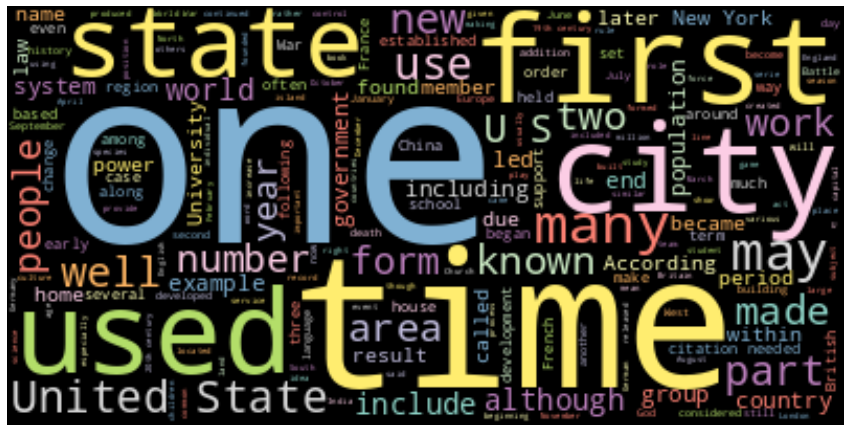

<Figure size 720x432 with 0 Axes>

CPU times: user 27.9 s, sys: 920 ms, total: 28.8 s
Wall time: 29.7 s


In [28]:
%%time

# Generating wordcloud for the complete dataset
generate_wordcloud(complete_data)

The task of **Question and Answering** is difficult, as there are multiple documents and the answer can be in 1 or more documents. Thus, the retriever above returns **k** documents.
<br><br>
But, **TF-IDF** suffers from the following couple of  problems :- 
<br>
(1) Its able to compute only the similarity between questions and documents that present the same words, so it can not capture synonyms.
<br>
(2) It cannot understand the question context or the meaning of the words.